## Comparison of profiles between KPP and LES 

Compare velocity and temperature profiles simulated in GOTM with KPP-CVMix to those in LES in the LES cases of [Li and Fox-Kemper, 2017](https://doi.org/10.1175/JPO-D-17-0085.1).

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import GOTMOutputData
np.seterr(all='raise')
%matplotlib inline

In [2]:
def plot_profile_les_gotm(pfl_les, time_les, z_les,
                          pfl_gotm, time_gotm, z_gotm,
                          time_plot, color='k', axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    tidx_les  = np.argmin(np.abs(time_les-time_plot))
    tidx_gotm = np.argmin(np.abs(time_gotm-time_plot))
    p1, = axis.plot(pfl_les[tidx_les,:], z_les, '-', color=color)
    p2, = axis.plot(pfl_gotm[tidx_gotm,:], z_gotm, '--', color=color)
    return [p1, p2]

### Load data 

In [3]:
# LES
casename = 'BF05WD10WV00'
les_root = os.environ['HOME']+'/data/NCARLES/archive_les/hist'
dir_les = les_root+'/R7_'+casename+'_ST00_ens01'
fname_les = sorted(os.listdir(dir_les))[0]
infile_les = dir_les+'/'+fname_les
dataset_les = Dataset(infile_les, 'r')
txym_les = dataset_les.variables['txym'][:,0,:]-273.
uxym_les = dataset_les.variables['uxym'][:,:]
vxym_les = dataset_les.variables['vxym'][:,:]
zu_les   = dataset_les.variables['z_u'][:]
time_les = dataset_les.variables['time'][:]

In [4]:
# gotm KPP-CVMix
gotm_root = os.environ['GOTMRUN_ROOT']+'/LF17_r2/KPP-CVMix'
infile_gotm = gotm_root+'/R7_'+casename+'/gotm_out.nc'
godat = GOTMOutputData(path=infile_gotm)
txym_gotm = godat.read_profile('temp').data
uxym_gotm = godat.read_profile('u').data
vxym_gotm = godat.read_profile('v').data
godat.open()
time_gotm = godat.dataset.variables['time'][:]
zu_gotm   = godat.dataset.variables['z'][0,:,0,0]
godat.close()

In [5]:
# figure path
fig_root = os.environ['GOTMFIG_ROOT']+'/LF17_r2'
os.makedirs(fig_root, exist_ok=True)

### Time series of $u(0)$ and $v(0)$ 

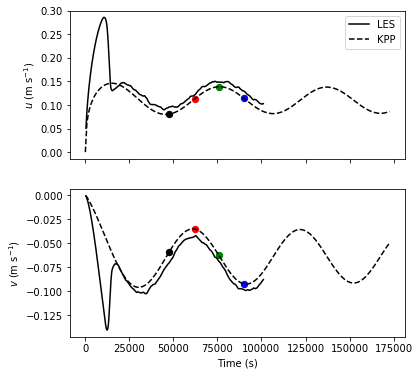

In [6]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(6, 6)
axarr[0].plot(time_les, uxym_les[:,0], '-k', label='LES')
axarr[0].plot(time_gotm, uxym_gotm[:,-1], '--k', label='KPP')
axarr[0].set_ylabel('$u$ (m s$^{-1}$)')
axarr[0].legend(loc='upper right')
axarr[1].plot(time_les, vxym_les[:,0], '-k')
axarr[1].plot(time_gotm, vxym_gotm[:,-1], '--k')
axarr[1].set_ylabel('$v$ (m s$^{-1}$)')
axarr[1].set_xlabel('Time (s)')

# profiles at four times
time_plots = [48000, 62000, 76000, 90000]
color_plots = ['k', 'r', 'g', 'b']
for i, var in enumerate(time_plots):
    tidx = np.argmin(np.abs(time_gotm-var))
    axarr[0].scatter(time_gotm[tidx], uxym_gotm[tidx,-1], s=40, c=color_plots[i])
    axarr[1].scatter(time_gotm[tidx], vxym_gotm[tidx,-1], s=40, c=color_plots[i])

### Profiles of $u$, $v$ and $T$ 

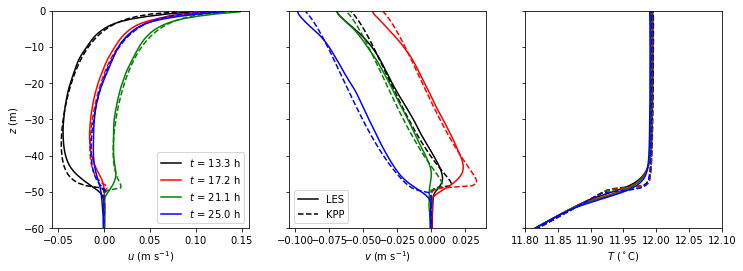

In [7]:
fig, axarr = plt.subplots(1,3, sharey='row')
fig.set_size_inches(12, 4)
pp = []
for i in np.arange(len(time_plots)):
    p = plot_profile_les_gotm(uxym_les, time_les, zu_les,
                          uxym_gotm, time_gotm, zu_gotm,
                          time_plot=time_plots[i],
                          color=color_plots[i],
                          axis=axarr[0])
    pp.append(p)
    plot_profile_les_gotm(vxym_les, time_les, zu_les,
                          vxym_gotm, time_gotm, zu_gotm,
                          time_plot=time_plots[i],
                          color=color_plots[i],
                          axis=axarr[1])
    plot_profile_les_gotm(txym_les, time_les, zu_les,
                          txym_gotm, time_gotm, zu_gotm,
                          time_plot=time_plots[i],
                          color=color_plots[i],
                          axis=axarr[2])
plt.ylim([-60, 0])
axarr[0].set_ylabel('$z$ (m)')
axarr[0].set_xlabel('$u$ (m s$^{-1}$)')
axarr[1].set_xlabel('$v$ (m s$^{-1}$)')
axarr[2].set_xlim([11.8, 12.1])
axarr[2].set_xlabel('$T$ ($^\circ$C)')

# add legend
plist = []
tlist = []
for i, val in enumerate(time_plots):
    plist.append(pp[i][0]) 
    tlist.append('$t$ = {:4.1f} h'.format(val/3600))
axarr[0].legend(plist, tlist, loc='lower right')
plist = []
tlist = ['LES', 'KPP']
for i in np.arange(2):
    plist.append(pp[0][i]) 
axarr[1].legend(plist, tlist, loc='lower left')

# save figure
figname = fig_root+'/kpp_profiles_'+casename+'.png'
plt.savefig(figname, dpi = 300)